# Consuming a Machine Learning Model
 

**Before** going forward make sure the server app is running and serving the model.

Run the `server_app.py` file in a terminal. This will sping up the server and keep waiting for requests.




# The client app

This notebook has a minimal client that uses Python's `requests` library to interact with your running server.

The `url`s:

1. The server is hosted in the URL [http://localhost:8000/](http://localhost:8000/).
2. The endpoint that serves your model is the `/predict` endpoint.


To consume your model, you append the endpoint to the base URL to get the full URL.

Also you can specify the model to use:  `yolov3` or`yolov3-tiny`. Let's stick to the tiny version for computational efficiency.


In [1]:
import os
import io
import cv2
import requests
import numpy as np
from IPython.display import Image, display

In [2]:
base_url = 'http://localhost:8000'
endpoint = '/predict'
model = 'yolov3-tiny'

In [3]:
url_with_endpoint_no_params = base_url + endpoint
url_with_endpoint_no_params

'http://localhost:8000/predict'

To set any of the expected parameters, the syntax is to add a "?" character followed by the name of the parameter and its value.

Let's do it and check how the final URL looks like:

In [4]:
full_url = url_with_endpoint_no_params + "?model=" + model
full_url

'http://localhost:8000/predict?model=yolov3-tiny'

This endpoint expects both a model's name and an image. But since the image is more complex it is not passed within the URL. Instead we leverage the `requests` library to handle this process.

To pass the file along with the request, you need to create a dictionary indicating the name of the file ('file' in this case) and the actual file.


In [7]:
def response_from_server(url, image_file, verbose=True):
    """Makes a POST request to the server and returns the response.

    Args:
        url (str): URL that the request is sent to.
        image_file (_io.BufferedReader): File to upload, should be an image.
        verbose (bool): True if the status of the response should be printed. False otherwise.

    Returns:
        requests.models.Response: Response from the server.
    """
    
    files = {'file': image_file}
    response = requests.post(url, files=files)
    status_code = response.status_code
    if verbose:
        msg = "Everything went well!" if status_code == 200 else "There was an error when handling the request."
        print(msg)
    return response

To test this function, open a file in your filesystem and pass it as a parameter alongside the URL:

In [8]:
with open("images/clock2.jpg", "rb") as image_file:
    prediction = response_from_server(full_url, image_file)

Everything went well!


To get the image with the bounding boxes and labels,  you need to parse the content of the response into an appropriate format. This process looks very similar to how you read raw images into a `cv2` image on the server.

To handle this step, let's create a directory called `images_predicted` to save the image to:


In [9]:
dir_name = "images_predicted"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)


### Creating the display_image_from_response function

In [11]:
def display_image_from_response(response):
    """Display image within server's response.

    Args:
        response (requests.models.Response): The response from the server after object detection.
    """
    
    image_stream = io.BytesIO(response.content)
    image_stream.seek(0)
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    filename = "image_with_objects.jpeg"
    cv2.imwrite(f'images_predicted/{filename}', image)
    display(Image(f'images_predicted/{filename}'))

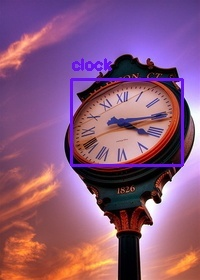

In [13]:
display_image_from_response(prediction)

Now you are ready to consume your object detection model through your own client!

Let's test it out on some other images:

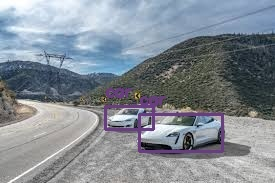

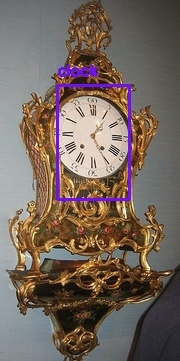

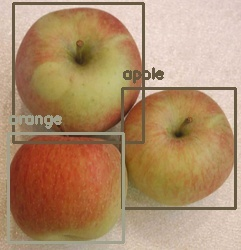

In [14]:
image_files = [
    'car2.jpg',
    'clock3.jpg',
    'apples.jpg'
]

for image_file in image_files:
    with open(f"images/{image_file}", "rb") as image_file:
        prediction = response_from_server(full_url, image_file, verbose=False)
    
    display_image_from_response(prediction)